In [1]:
#https://modelo.covid19.cdmx.gob.mx/modelo-epidemico
#https://github.com/ollin18/ComplexSystems.jl/blob/master/examples/CDMX_model.ipynb

import numpy as np
import matplotlib.pyplot as plt

VARS = ['susceptibles', 'infecciosos', 'expuestos', 'leve', 'grave', 'hospitalizados', 'uci', 'recuperados', 'muertos']

#por qué necesita esta distribucion?
def degree_dist(p, k_max):
    pk = np.zeros(k_max)
    #print(pk)
    for k in range(k_max-1):
        pk[k+1] = (1 - np.exp(-p)) * np.exp(-p * k)
    #print(pk)
    return pk

#Genera una matriz con los casos a probar (simulaciones?)
#[sus1 sus2 ... inf1 inf2 ... exp1 exp2 ... leve1 ... leve2 ...]
#inicia solo con susceptibles e infectados, lo demás en cero
def make_proportions(compart_num, init_infec):
    susceptible = 1 - prop_inf
    initial = np.array([susceptible, init_infec])
    for n in range(compart_num-2):
        initial = np.vstack((initial, np.zeros(len(init_infec))))
    return initial.flatten()

In [2]:
def CDMX(x, t, k_max, prop_deg):
    def iof(ind):
        n = VARS.index(ind)
        return x[(n * k_max):((n+1) * k_max)]    

    #Nombres en el modelo de CDMX (2020-05-14)
    R0=2.83         #Tasa de reproducción estimada
    Dinf=2.9        #Tiempo que es infeccioso el paciente
    Dincub=5.2      #Tiempo incubación
    Drl=11.1        #Tiempo recuperación casos intermedios
    Dhosp=5         #Días entre síntomas y hospitalización
    Drh=15          #Días totales de hospitalización
    Duci=2          #**No especificado en modelo: Dias en UCI
    Druci=14 #10    #**No especificado en modelo: Dias de recuperacion de UCI
    Dm=4            #**No especificado en modelo: Dias a muerte en UCI
    pgrav=0.15      #Tasa de hospitalización
    puci=0.05       #Tasa de UCI
    pm=0.035        #Tasa de mortalidad
    #Otros:
    #  Tiempo entre incubación y muerte [dias]: 32 
    #  Poblacion susceptible [millones]: 22 (ver en código)
    
    y = np.zeros(len(x))
    k_mult = np.arange(1, k_max+1) * prop_deg
    avg_k = np.sum(k_mult)
    further = np.sum(np.multiply(k_mult, iof('expuestos')))
    th = further / avg_k
    
    for k in range(k_max):
        d_sus = -(R0/Dinf) * iof('infecciosos')[k] * iof('susceptibles')[k]
        d_exp = (R0/Dinf) * iof('infecciosos')[k] * iof('susceptibles')[k] - (1/Dincub)*iof('expuestos')[k]
        d_inf = (1/Dincub) * iof('expuestos')[k] - (1/Dinf) * iof('infecciosos')[k]
        d_leve = (1-pgrav) * (1/Dinf) * iof('infecciosos')[k] - (1/Drl) * iof('leve')[k]
        d_grav = pgrav * (1/Dinf) * iof('infecciosos')[k] - (1/Dhosp) * iof('grave')[k]
        d_hosp = (1/Dhosp) * iof('grave')[k] - (1-puci) * (1/Drh) * iof('hospitalizados')[k] \
            - puci * (1/Duci)*iof('hospitalizados')[k]
        d_uci = puci * (1/Duci) * iof('hospitalizados')[k] - (1-pm) * (1/Druci) * iof('uci')[k] \
            - pm * (1/Dm) * iof('uci')[k]
        d_rec = (1/Drl) * iof('leve')[k] + (1-puci) * (1/Drh) * iof('hospitalizados')[k] \
            + (1-pm) * (1/Druci) * iof('uci')[k]
        d_mue = pm * (1/Dm) * iof('uci')[k]

        y[k] = d_sus
        y[k_max + k] = d_inf
        y[2*k_max + k] = d_exp
        y[3*k_max + k] = d_leve
        y[4*k_max + k] = d_grav
        y[5*k_max + k] = d_hosp
        y[6*k_max + k] = d_uci
        y[7*k_max + k] = d_rec
        y[8*k_max + k] = d_mue
            
    return y

In [3]:
#numero de "escenarios"
k_max = 200

p = 0.4
infec = np.random.rand(k_max)
all_infec = sum(infec)
prop_inf = infec / all_infec
prop_inf

array([4.35814756e-03, 1.62419057e-03, 1.16671794e-03, 2.73959032e-03,
       6.89195058e-03, 8.48718580e-03, 5.93032812e-03, 8.93529238e-03,
       8.46360101e-03, 9.80745630e-03, 2.30284548e-03, 8.66848737e-03,
       8.67248046e-03, 4.18604886e-03, 9.59248646e-04, 9.10465618e-03,
       8.46860127e-03, 1.25223932e-03, 1.21646313e-03, 9.61727769e-03,
       1.56908768e-03, 3.17504536e-03, 8.07898586e-03, 1.54932526e-03,
       1.01704090e-03, 5.72958841e-04, 9.24376112e-04, 6.56206196e-04,
       8.13425329e-03, 7.36925573e-03, 2.04199827e-03, 7.12680844e-03,
       4.84498640e-03, 9.60551111e-03, 3.76606542e-03, 8.37573930e-03,
       3.81137653e-04, 6.22377451e-03, 4.91643267e-03, 9.83606863e-03,
       7.48527540e-03, 4.94370580e-04, 5.35025818e-03, 8.79660020e-03,
       5.02196125e-05, 8.82254655e-04, 3.29690941e-04, 5.69046967e-03,
       4.45462640e-05, 8.93100374e-03, 2.81986676e-03, 6.86851305e-03,
       1.96416532e-03, 7.51147275e-03, 2.64863127e-03, 1.98646755e-04,
      

In [4]:
np.sum(prop_inf * np.arange(1, k_max+1))

102.93083408067736

In [5]:
the_proportions = make_proportions(9, prop_inf)
the_proportions
len(the_proportions)

1800

[0.         0.32967995 0.22099108 0.14813475 0.09929769 0.06656123
 0.04461733 0.02990789 0.02004786 0.01343848]


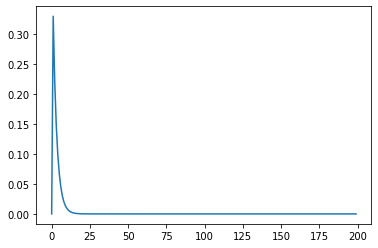

In [6]:
#pd es el parámetro prop_deg del modelo (qué es?)
pd = degree_dist(p, k_max)
print(pd[:10])
#sum(pd)
plt.plot(pd)

In [7]:
np.sum(np.multiply(pd, np.arange(1, k_max+1)))

4.033244781719736

In [8]:
from scipy.integrate import odeint
t = np.arange(0, 101, 1)
y1 = odeint(CDMX, the_proportions, t, args=(k_max, pd))

In [9]:
y1.shape

(101, 1800)

In [10]:
print(y1[0].shape)
y1[0]

(1800,)


array([0.99564185, 0.99837581, 0.99883328, ..., 0.        , 0.        ,
       0.        ])

In [11]:
susceptibles = [np.sum(np.multiply(ye[:k_max], pd)) for ye in y1]
print(len(susceptibles))
susceptibles

101


[0.9965739983943203,
 0.9936855598296829,
 0.9912397942778182,
 0.9888276553236554,
 0.9862175703614213,
 0.9832602428423876,
 0.9798418759998222,
 0.9758609550352564,
 0.9712166724903979,
 0.965803266164725,
 0.9595075394867061,
 0.9522083008050453,
 0.9437771921002833,
 0.9340807166528674,
 0.9229834019117871,
 0.9103520393647714,
 0.8960609114215008,
 0.8799977261244575,
 0.8620699055997844,
 0.8422106966955181,
 0.820384562570769,
 0.796591369794993,
 0.7708690849680879,
 0.7432949940957587,
 0.7139857833917098,
 0.6830970035502439,
 0.6508224245580123,
 0.6173934920067422,
 0.5830786025743765,
 0.5481813959497632,
 0.5130369261111896,
 0.47800462775797203,
 0.44345744391555264,
 0.40976732505019553,
 0.3772882418072754,
 0.3463386257499264,
 0.31718556173088797,
 0.2900328640136775,
 0.26501455301447885,
 0.24219427985557218,
 0.22157022706525425,
 0.20308427303392673,
 0.1866337388929401,
 0.17208401629876538,
 0.15928065385836818,
 0.1480598939225417,
 0.13825714430899644,
 0.12

In [12]:
res = {}
for index, var in enumerate(VARS):
    fr = k_max * index
    to = k_max * (index+1)
    res[var] = [np.sum(np.multiply(ye[fr:to], pd)) for ye in y1] 

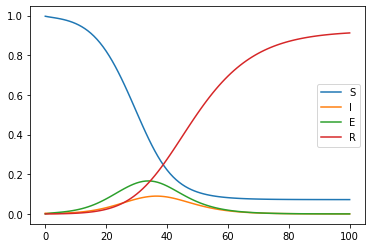

In [13]:
plt.plot(t, res['susceptibles'], label="S")
plt.plot(t, res['infecciosos'], label="I")
plt.plot(t, res['expuestos'], label="E")
#y esto por qué crece?
plt.plot(t, res['recuperados'], label="R")
plt.legend()

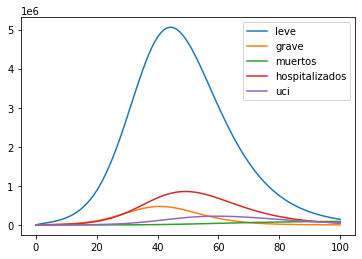

In [14]:
poblacion = 22000000
for var in ['leve', 'grave', 'muertos', 'hospitalizados', 'uci']:
    plt.plot(t, np.multiply(res[var], poblacion), label=var)
plt.legend()

In [18]:
max(res["uci"]) * poblacion

223241.25902689042

In [19]:
max(res["muertos"]) * poblacion

90104.94021877166